In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import random
import heapq
import time
from collections import deque

random.seed(42)
np.random.seed(42)

In [3]:
def generate_maze(rows, cols):
    if rows%2 == 0 or cols%2 == 0:
        raise ValueError("Rows and columns must be odd numbers.")
    
    maze = np.ones((rows, cols), dtype=int)

    start_r = random.randrange(1, rows, 2)
    start_c = random.randrange(1, cols, 2)

    maze[start_r, start_c] = 0

    walls = []

    directions = [(0, 2), (2, 0), (0, -2), (-2, 0)]
    for dr, dc in directions:
        nr, nc = start_r + dr, start_c + dc
        if 1 <= nr < rows - 1 and 1 <= nc < cols - 1:
            if maze[nr, nc] == 1:
                walls.append((start_r, start_c, nr, nc))

    while walls:
        wall_idx = random.randint(0, len(walls) - 1)
        r1, c1, r2, c2 = walls.pop(wall_idx)

        if maze[r2, c2] == 1:
            adjacent_passages = 0
            for dr, dc in directions:
                nr, nc = r2 + dr, c2 + dc
                if 0 <= nr < rows and 0 <= nc < cols and maze[nr, nc] == 0:
                    adjacent_passages += 1

            if adjacent_passages == 1:
                maze[r2, c2] = 0
                maze[r1 + (r2 - r1) // 2, c1 + (c2 - c1) // 2] = 0

                for dr, dc in directions:
                    nr, nc = r2 + dr, c2 + dc
                    if 1 <= nr < rows - 1 and 1 <= nc < cols - 1:
                        if maze[nr, nc] == 1:
                            walls.append((r2, c2, nr, nc))

    return maze

In [6]:
def place_start_goal(maze):
    rows, cols = maze.shape
    maze_copy = maze.copy()

    start = (1, 1)
    goal = (rows - 2, cols - 2)

    if maze_copy[start] == 0:
        maze_copy[start] = 2
    else:
        for r in range(1, rows , 2):
            for c in range(1, cols, 2):
                if maze_copy[r, c] == 0:
                    start = (r, c)
                    maze_copy[start] = 2
                    break
            else:
                continue
            break

    if maze_copy[goal] == 0:
        maze_copy[goal] = 3
    else:
        for r in range(rows - 2, 0, -2):
            for c in range(cols - 2, 0, -2):
                if maze_copy[r, c] == 0:
                    goal = (r, c)
                    maze_copy[goal] = 3
                    break
            else:
                continue
            break
    return maze_copy, start, goal


def get_neighbors(pos, maze):
    r, c = pos
    neighbors = []
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    
    for dr, dc in directions:
        nr, nc = r + dr, c + dc
        if 0 <= nr < maze.shape[0] and 0 <= nc < maze.shape[1] and maze[nr, nc] != 1:
            neighbors.append((nr, nc))
    
    return neighbors

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

In [7]:
def plot_maze(maze, path=None, start=None, goal=None):
    cmap = ListedColormap(['white', 'black', 'orange', 'red', 'green', 'blue'])
    plt.imshow(maze, cmap=cmap, origin='upper')
    
    import matplotlib.patches as mpatches
    legend_elements = [
        mpatches.Patch(color='white', label='Path'),
        mpatches.Patch(color='black', label='Wall'),
        mpatches.Patch(color='orange', label='Start'),
        mpatches.Patch(color='red', label='Goal'),
        mpatches.Patch(color='green', label='Visited'),
        mpatches.Patch(color='blue', label='Final Path')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [10]:
def a_star(maze, start, goal):
    start_time = time.time()
    maze_final = maze.copy()

    heap = [(0, 0, start, [start])]

    visited = set()
    g_costs = {start: 0}
    search_steps = []

    nodes_visited = 0

    while heap:
        f_cost, g_cost, current, path = heapq.heappop(heap)

        if current in visited:
            continue

        visited.add(current)
        nodes_visited += 1

        if current != start and current != goal:
            maze_final[current] = 4

        
        search_steps.append({
            'maze': maze_final.copy(),
            'current': current,
            'path': path.copy()
        })
        if current == goal:
            final_maze = maze_final.copy()
            for pos in path:
                if pos != start and pos != goal:
                    final_maze[pos] = 5  
            end_time = time.time()
            
            stats = {
                'nodes_visited': nodes_visited,
                'path_length': len(path),
                'execution_time': end_time - start_time
            }
            
            return path, final_maze, search_steps, stats
        
        for neighbor in get_neighbors(current, maze):
            if neighbor in visited:
                continue
            
            tentative_g_cost = g_cost + 1
            
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                heapq.heappush(heap, (f_cost, tentative_g_cost, neighbor, path + [neighbor]))

    end_time = time.time()
    stats = {
        'nodes_visited': nodes_visited,
        'path_length': 0,
        'execution_time': end_time - start_time
    }
    return None, maze_final, search_steps, stats

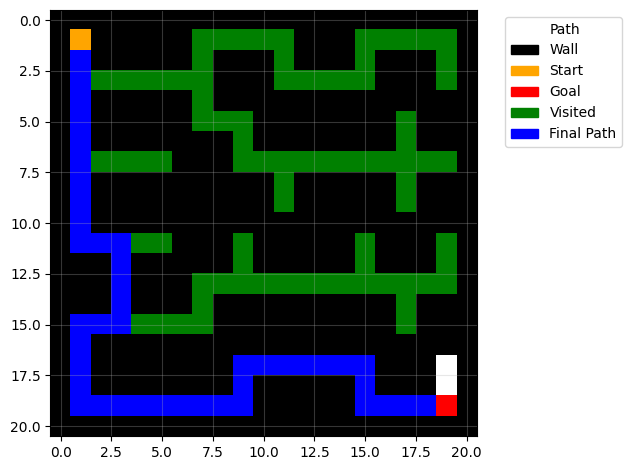

In [24]:
maze = generate_maze(21, 21)
maze_with_sg, start_pos, goal_pos = place_start_goal(maze)
path, final_maze, search_steps, stats = a_star(maze_with_sg, start_pos, goal_pos)

plot_maze(final_maze, path=path, start=start_pos, goal=goal_pos)

In [14]:
print(f"path found: {'True' if path else 'False'}")
print(f"path length: {stats['path_length']}")
print(f"nodes visited: {stats['nodes_visited']}")
print(f"execution time: {stats['execution_time']:.4f} seconds")

path found: True
path length: 45
nodes visited: 91
execution time: 0.0008 seconds


In [ ]:
import pygame

COLOR_MAP = {
    0: (255, 255, 255),  # path
    1: (0, 0, 0),        # wall
    2: (255, 165, 0),    # start
    3: (255, 0, 0),      # goal
    4: (0, 255, 0),      # visited
    5: (0, 0, 255),      # final path
}


def draw_maze(screen, maze, current, cell_size):
    for row in range(maze.shape[0]):
        for col in range(maze.shape[1]):
            value = maze[row, col]
            color = COLOR_MAP.get(value, (200, 200, 200))
            rect = pygame.Rect(col * cell_size, row * cell_size, cell_size, cell_size)
            pygame.draw.rect(screen, color, rect)
            pygame.draw.rect(screen, (180, 180, 180), rect, 1)  # grid lines
    if current:
        pygame.draw.circle(screen, (255, 255, 0), 
            (current[1]*cell_size + cell_size//2, current[0]*cell_size + cell_size//2), 
            cell_size//3)

        
def run_pygame_visualization(search_steps, maze_shape):
    pygame.init()
    cell_size = 25
    width, height = maze_shape[1] * cell_size, maze_shape[0] * cell_size
    screen = pygame.display.set_mode((width, height + 50))
    pygame.display.set_caption("A* Maze Visualizer")

    font = pygame.font.SysFont(None, 36)
    button = pygame.Rect(width//2 - 50, height + 10, 100, 30)

    running = True
    started = False
    step_index = 0
    clock = pygame.time.Clock()

    while running:
        screen.fill((255, 255, 255))
        pygame.draw.rect(screen, (0, 128, 0), button)
        text = font.render("Start", True, (255, 255, 255))
        screen.blit(text, (button.x + 15, button.y + 2))

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            if event.type == pygame.MOUSEBUTTONDOWN:
                if button.collidepoint(event.pos):
                    started = True

        if started and step_index < len(search_steps):
            maze = search_steps[step_index]['maze']
            current = search_steps[step_index]['current']
            draw_maze(screen, maze, current, cell_size)
            step_index += 1
            pygame.time.wait(50)  # delay between steps
        elif not started:
            draw_maze(screen, search_steps[0]['maze'], None, cell_size)
        else:
            draw_maze(screen, search_steps[-1]['maze'], None, cell_size)

        pygame.display.flip()
        clock.tick(60)

    pygame.quit()


In [29]:
run_pygame_visualization(search_steps, maze_with_sg.shape)